## Análise da Curva ROC para Detecção de Intruso (Atividade 8)

Este notebook realiza uma análise mais aprofundada do desempenho dos classificadores na tarefa de controle de acesso (Atividade 8). Em vez de olhar para um único ponto de decisão (o `argmax` da saída), vamos analisar o comportamento do classificador em todos os limiares de decisão possíveis.

**Objetivo:** Gerar a Curva ROC (Receiver Operating Characteristic) e calcular a AUC (Area Under the Curve) para os melhores modelos da Atividade 8. Isso nos dá uma medida de desempenho que é independente do limiar de decisão e é o padrão para avaliar classificadores binários em cenários como segurança.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Adiciona o diretório raiz do projeto ao path para importar os módulos
module_path = os.path.abspath(os.path.join('..', '..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Importa os componentes necessários do projeto
from trabalho_ic_aplicada.dataset_faces import build_face_dataset
from src.tc2_faces_A8 import (
    train_test_split_stratified, 
    fit_boxcox_then_zscore, 
    transform_boxcox_then_zscore, 
    MQSampler, PLSampler, MLP1HSampler, MLP2HSampler
)
from trabalho_ic_aplicada.models.pca_np import PCA_np

2025-08-28 09:49:10.128 | INFO     | trabalho_ic_aplicada.config:<module>:11 - PROJ_ROOT path is: /home/apo-note/Documents/Github/Trabalhos_IC_Aplicada


### 1. Carregar Dados e Configurações

Vamos carregar o dataset completo (incluindo intrusos) e os melhores hiperparâmetros encontrados na Atividade 8, que estão salvos em `results/TC2/tabela4_intruso.csv`.

In [2]:
DATA_ROOT = '../../data/raw/Kit_projeto_FACES'
RESULTS_DIR = '../../results/TC2'
IMG_SIZE = (20, 20)

# Carregar dataset
X, y, idx2class = build_face_dataset(DATA_ROOT, size=IMG_SIZE, load_intruders=True)

In [3]:
idx2class

{0: 'intruder',
 1: 'subject01',
 2: 'subject02',
 3: 'subject03',
 4: 'subject04',
 5: 'subject05',
 6: 'subject06',
 7: 'subject07',
 8: 'subject08',
 9: 'subject09',
 10: 'subject10',
 11: 'subject11',
 12: 'subject12',
 13: 'subject13',
 14: 'subject14',
 15: 'subject15'}

In [4]:

# Identificar classe do intruso
intruder_ids = [k for k, v in idx2class.items() if not v.lower().startswith("subject")]
intruder_id = intruder_ids[0]
print(f"Dataset carregado. Shape: {X.shape}, {y.shape}. ID do Intruso: {intruder_id}")

# Carregar melhores parâmetros da Tabela 4
try:
    df_a8 = pd.read_csv(os.path.join(RESULTS_DIR, 'tabela4_intruso.csv'))
    # Converte colunas de string para tipos numéricos adequados
    for col in ['LR', 'Epochs', 'L2', 'Clip']:
        if col in df_a8.columns:
            df_a8[col] = pd.to_numeric(df_a8[col], errors='coerce')
    print("Tabela de resultados da Atividade 8 carregada.")
except FileNotFoundError:
    print("Arquivo 'tabela4_intruso.csv' não encontrado. Execute o script da Atividade 8 primeiro.")
    df_a8 = None

# Obter q* (dimensão reduzida do PCA)
q_star = int(df_a8.iloc[0]['q']) if df_a8 is not None else 10 # Fallback para 10
print(f"Dimensão do PCA (q*): {q_star}")

Dataset carregado. Shape: (175, 400), (175,). ID do Intruso: 0
Tabela de resultados da Atividade 8 carregada.
Dimensão do PCA (q*): 10


### 2. Função para Gerar e Plotar a Curva ROC

In [5]:
import numpy as np
import pandas as pd

def _safe_get(d, key, default=None, cast=None):
    # Safely pop a key from a dict built from a pandas row, handling NaN/None/empty.
    v = d.pop(key, default)
    if v is None or (isinstance(v, float) and np.isnan(v)) or (isinstance(v, str) and v.strip() == ""):
        v = default
    if cast is not None and v is not None:
        v = cast(v)
    return v

def plot_roc_for_model(model_name, X, y, q, intruder_id, params_row, sampler_class):
    """Treina um modelo com os parâmetros dados, calcula e plota a curva ROC."""
    # 1. Preparar dados (split, PCA, Box-Cox) - usamos uma semente fixa para consistência
    rng = np.random.default_rng(42)
    tr, te = train_test_split_stratified(y, 0.8, rng)
    Xtr, Xte, ytr, yte = X[tr], X[te], y[tr], y[te]

    pca = PCA_np(q=q)
    Xtr_p = pca.fit_transform(Xtr, q=q)
    Xte_p = pca.transform(Xte, q=q)

    Xtr_n, bx_params = fit_boxcox_then_zscore(Xtr_p)
    Xte_n = transform_boxcox_then_zscore(Xte_p, bx_params)

    # 2. Instanciar e treinar o modelo
    params = params_row.to_dict()
    # Rename/convert with robust defaults
    params['lr'] = _safe_get(params, 'LR', 0.01, float)

    # Only set epochs for models that actually train for multiple epochs
    name_l = str(model_name).lower()
    needs_epochs = ('mlp' in name_l) or ('pl' in name_l)  # adjust if 'pl' doesn't need epochs
    if needs_epochs:
        params['epochs'] = _safe_get(params, 'Epochs', 100, int)

    params['l2'] = _safe_get(params, 'L2', 0.0, float)
    params['clip_grad'] = _safe_get(params, 'Clip', 5.0, float)

    # If your sampler/model expects only specific keys, you may wish to prune extraneous ones here.
    # Lida com o formato de 'hidden' que é uma string no CSV
    if 'Hidden' in params and isinstance(params['Hidden'], str) and params['Hidden'] != 'nan':
        try: params['hidden'] = eval(params['Hidden'])
        except: params['hidden'] = None
    else:
        params['hidden'] = None

    # Renomeia colunas para corresponder aos argumentos do construtor
    params['activation'] = params.pop('Act', 'relu')
    params['opt'] = params.pop('Opt', 'adam')
    
    sampler = sampler_class()
    model = sampler.to_model(params)
    model.fit(Xtr_n, ytr, n_classes=int(y.max()) + 1)

    # 3. Obter probabilidades para a classe intruso
    probas = model.predict_proba(Xte_n)
    probas_intruder = probas[:, intruder_id]
    y_true_bin = (yte == intruder_id).astype(int)

    # 4. Calcular ROC e AUC
    fpr, tpr, thresholds = roc_curve(y_true_bin, probas_intruder)
    roc_auc = auc(fpr, tpr)

    # 5. Plotar
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
    return roc_auc

Gerando ROC para MQ...
Gerando ROC para PL...
Gerando ROC para MLP-1H...
Gerando ROC para MLP-2H...


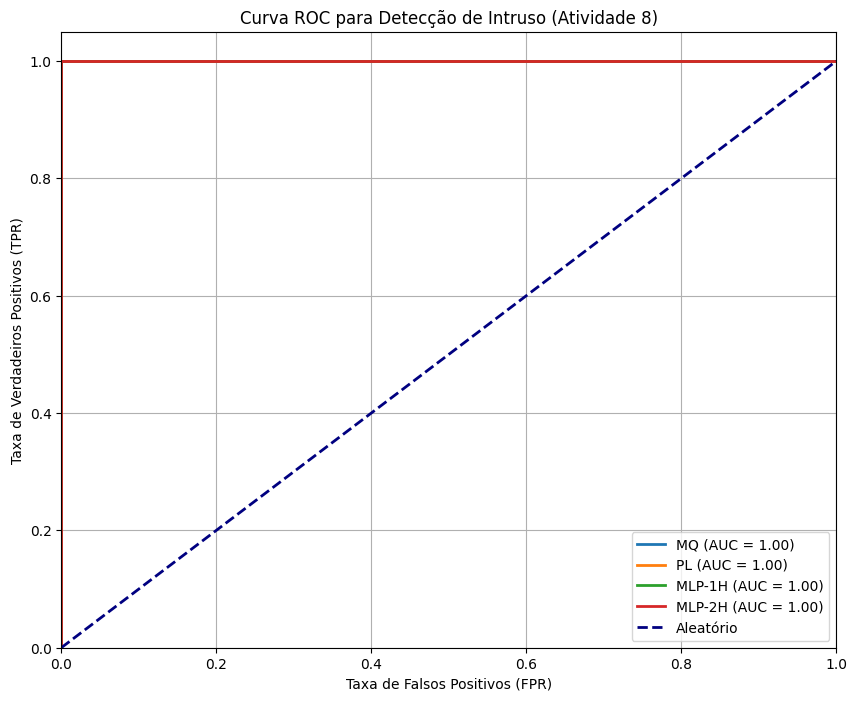

In [6]:
if df_a8 is not None:
    plt.figure(figsize=(10, 8))
    
    model_map = {
        'MQ': MQSampler,
        'PL': PLSampler,
        'MLP-1H': MLP1HSampler,
        'MLP-2H': MLP2HSampler
    }

    for model_name, sampler_class in model_map.items():
        params_row = df_a8[df_a8['Model'] == model_name].iloc[0]
        print(f"Gerando ROC para {model_name}...")
        plot_roc_for_model(model_name, X, y, q_star, intruder_id, params_row, sampler_class)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatório')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos (FPR)')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
    plt.title('Curva ROC para Detecção de Intruso (Atividade 8)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.savefig(os.path.join(RESULTS_DIR, 'roc_curve_A8.png'), dpi=150)
    plt.show()
else:
    print("Não foi possível gerar o gráfico ROC pois a tabela de resultados da A8 não foi carregada.")